In [1]:
cd ..

C:\Users\dthiex\Documents\Fork\dton-wildfires-cleaner\notebooks


In [2]:
cd ..

C:\Users\dthiex\Documents\Fork\dton-wildfires-cleaner


In [3]:
import os

from sentinelhub import SHConfig, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, MimeType, DownloadRequest, CRS, BBox, SHConfig, bbox_to_dimensions, Geometry
from utils import plot_image

In [4]:
CLIENT_ID = os.environ['CLIENT_ID']
CLIENT_SECRET = os.environ['CLIENT_SECRET']

In [5]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

Background choosen setting:  

S1 in general good to detect water as:
- independent of daytime/weather condition (quite often on the flood day there are a lot of clouds due to rain)

[Modes](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes):
- IW good as it is primary conflict-free mode (with VV+VH polarisation over land)
  - covers most of the area where floods happen, unfrozen land, see last image [here](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-1/observation-scenario)
- EW mainly over polar zones where are no floods --> not useful

References about the background why Radar (S1) can be used for detection of water and floods
- Paper by Solbo/Solheim 2005:https://www.researchgate.net/publication/240356618_Towards_Operational_Flood_Mapping_with_Satellite_SAR
- Researchgat threat: https://www.researchgate.net/post/SAR_images_show_water_in_dark_tone_Is_it_due_to_reflection_or_absorption

In [6]:
# Defining the bbox and resolution
resolution = 200
bbox = BBox(bbox=[53.974438, 36.783992, 54.731124, 37.122109], crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {bbox_size} pixels')

Image shape at 200 m resolution: (342, 178) pixels


In [7]:
# data fusion between S1 to detect water and S2 for True Color Visualization of non water bodies
# in the evalscript the const water_threshold is used to distingues between water area and non water area
# with using VV polarization a good water threshold to start with is 0.16
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [
        {datasource: "s1", bands: ["VV"]},
        {datasource: "l2a", bands: ["B02", "B03", "B04"], units: "REFLECTANCE"}
    ],
    output: { bands: 3 }
  }
}

function evaluatePixel(samples) {
    var s1 = samples.s1[0];
    var l2a = samples.l2a[0];
    const water_threshold = 0.16
    const decible_gamma0 = Math.max(0, Math.log(s1.VV) * 0.21714724095 + 1);
      if (decible_gamma0 < water_threshold)
        return [0, 0, 1];
      else
        return [2.5*l2a.B04, 2.5*l2a.B03, 2.5*l2a.B02];
}
"""

In [8]:
# build processing request using above defined parameters (evalscript, bbox, size)
request_image = SentinelHubRequest(
  evalscript=evalscript,
  input_data=[
    SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1_IW_ASC,
        time_interval=('2019-03-05', '2019-03-05'),    
        other_args = {"id":"s1","dataFilter":{"resolution":"HIGH"},"processing":{"orthorectify":"true","demInstance":"COPERNICUS","backCoeff":"GAMMA0_TERRAIN"}}
    ),
    SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
         time_interval=('2019-03-06', '2019-03-06'),    
         other_args = {"id":"l2a"}  
    ),
  ],
  responses=[
    SentinelHubRequest.output_response('default', MimeType.PNG),
  ],
  bbox=bbox,  
  size=bbox_size,
  config=config
)

In [9]:
# request image from sh
testimage = request_image.get_data() 

Image type: uint8


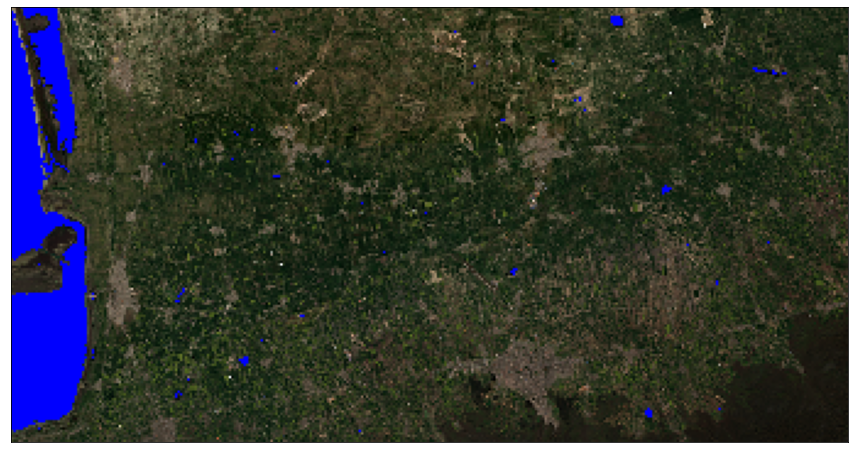

In [10]:
image = testimage[0]
print(f'Image type: {image.dtype}')

plot_image(image, factor=1/255)